# Learning to stabilize nonlinear ODE

For this example we demonstrate learning to stabilize an underactuated nonlinear ODE system using [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981). 

**Differentiable Predictive Control method**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In DPC, we construct a differentiable closed-loop system composed of neural control policy and system dynamics model that is to be optimized using parametric control objectives as intrinsic reward signals evaluated over a sampled distribution of the problem parameters.

<img src="./figs/DPC_simple_method.png" width="600">  

system: [Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator)  
see section V.A in for system equations: https://arxiv.org/abs/2203.14114  
objective: stabilize towards origin   


## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

In [1]:
import torch
import torch.nn as nn
import numpy as np

import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase

## Ground truth system model

In [2]:
gt_model = psl.nonautonomous.VanDerPolControl()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = -5.
umax = 5.
xmin = -4.
xmax = 4.

## Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [3]:
nsteps = 50  # prediction horizon
n_samples = 2000    # number of sampled scenarios
# Training dataset generation
train_data = DictDataset({'x': torch.randn(n_samples, 1, nx),
                          'r': torch.zeros(n_samples, nsteps+1, nx)}, name='train')
# Development dataset generation
dev_data = DictDataset({'x': torch.randn(n_samples, 1, nx),
                        'r': torch.zeros(n_samples, nsteps+1, nx)}, name='dev')
# torch dataloaders
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

## System model and Control policy in Neuromancer

In [6]:
# white-box ODE model with no-plant model mismatch
vdp_ode = ode.VanDerPolControl()
vdp_ode.mu = nn.Parameter(torch.tensor(gt_model.mu), requires_grad=False)

# integrate continuous time ODE
interp_u = lambda tq, t, u: u
integrator = integrators.RK4(vdp_ode, h=torch.tensor(ts), interp_u=interp_u)
# symbolic system model
model = Node(integrator, ['x', 'u'], ['x'], name='model')

# concatenate control parameters x and r into a vector xi
cat_fun = lambda x, r: torch.cat([x, r], dim=-1)
params = Node(cat_fun, ['x', 'r'], ['xi'], name='params')

# neural net control policy
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['xi'], ['u'], name='policy')

# closed-loop system model
cl_system = System([params, policy, model], nsteps=nsteps)
# cl_system.show()

## Differentiable Predictive Control objectives and constraints

In [7]:
# state and reference variables
x = variable('x')
ref = variable("r")
# objectives
regulation_loss = 100. * ((x == ref) ^ 2)  # target posistion
# state bound constraints
state_lower_bound_penalty = 10.0*(x > xmin)
state_upper_bound_penalty = 10.0*(x < xmax)
# state terminal penalties
terminal_lower_bound_penalty = 20.0*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 20.0*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]


## Differentiable optimal control problem 

In [8]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
# problem.show()

## Solve the problem


In [10]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader, dev_loader,
    optimizer,
    epochs=50,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)

epoch: 0  train_loss: 131.78160095214844
epoch: 1  train_loss: 110.04478454589844
epoch: 2  train_loss: 91.88853454589844
epoch: 3  train_loss: 77.98422241210938
epoch: 4  train_loss: 69.43379211425781
epoch: 5  train_loss: 64.83624267578125
epoch: 6  train_loss: 62.34465789794922
epoch: 7  train_loss: 60.90686798095703
epoch: 8  train_loss: 60.002525329589844
epoch: 9  train_loss: 59.38921356201172
epoch: 10  train_loss: 58.950096130371094
epoch: 11  train_loss: 58.622215270996094
epoch: 12  train_loss: 58.36979293823242
epoch: 13  train_loss: 58.17036819458008
epoch: 14  train_loss: 58.00940704345703
epoch: 15  train_loss: 57.877288818359375
epoch: 16  train_loss: 57.767242431640625
epoch: 17  train_loss: 57.674224853515625
epoch: 18  train_loss: 57.594627380371094
epoch: 19  train_loss: 57.52580642700195
epoch: 20  train_loss: 57.46574783325195
epoch: 21  train_loss: 57.412925720214844
epoch: 22  train_loss: 57.36613845825195
epoch: 23  train_loss: 57.324424743652344
epoch: 24  trai

<All keys matched successfully>

# Evaluate best model on a system rollout 



Test Closed Loop System 



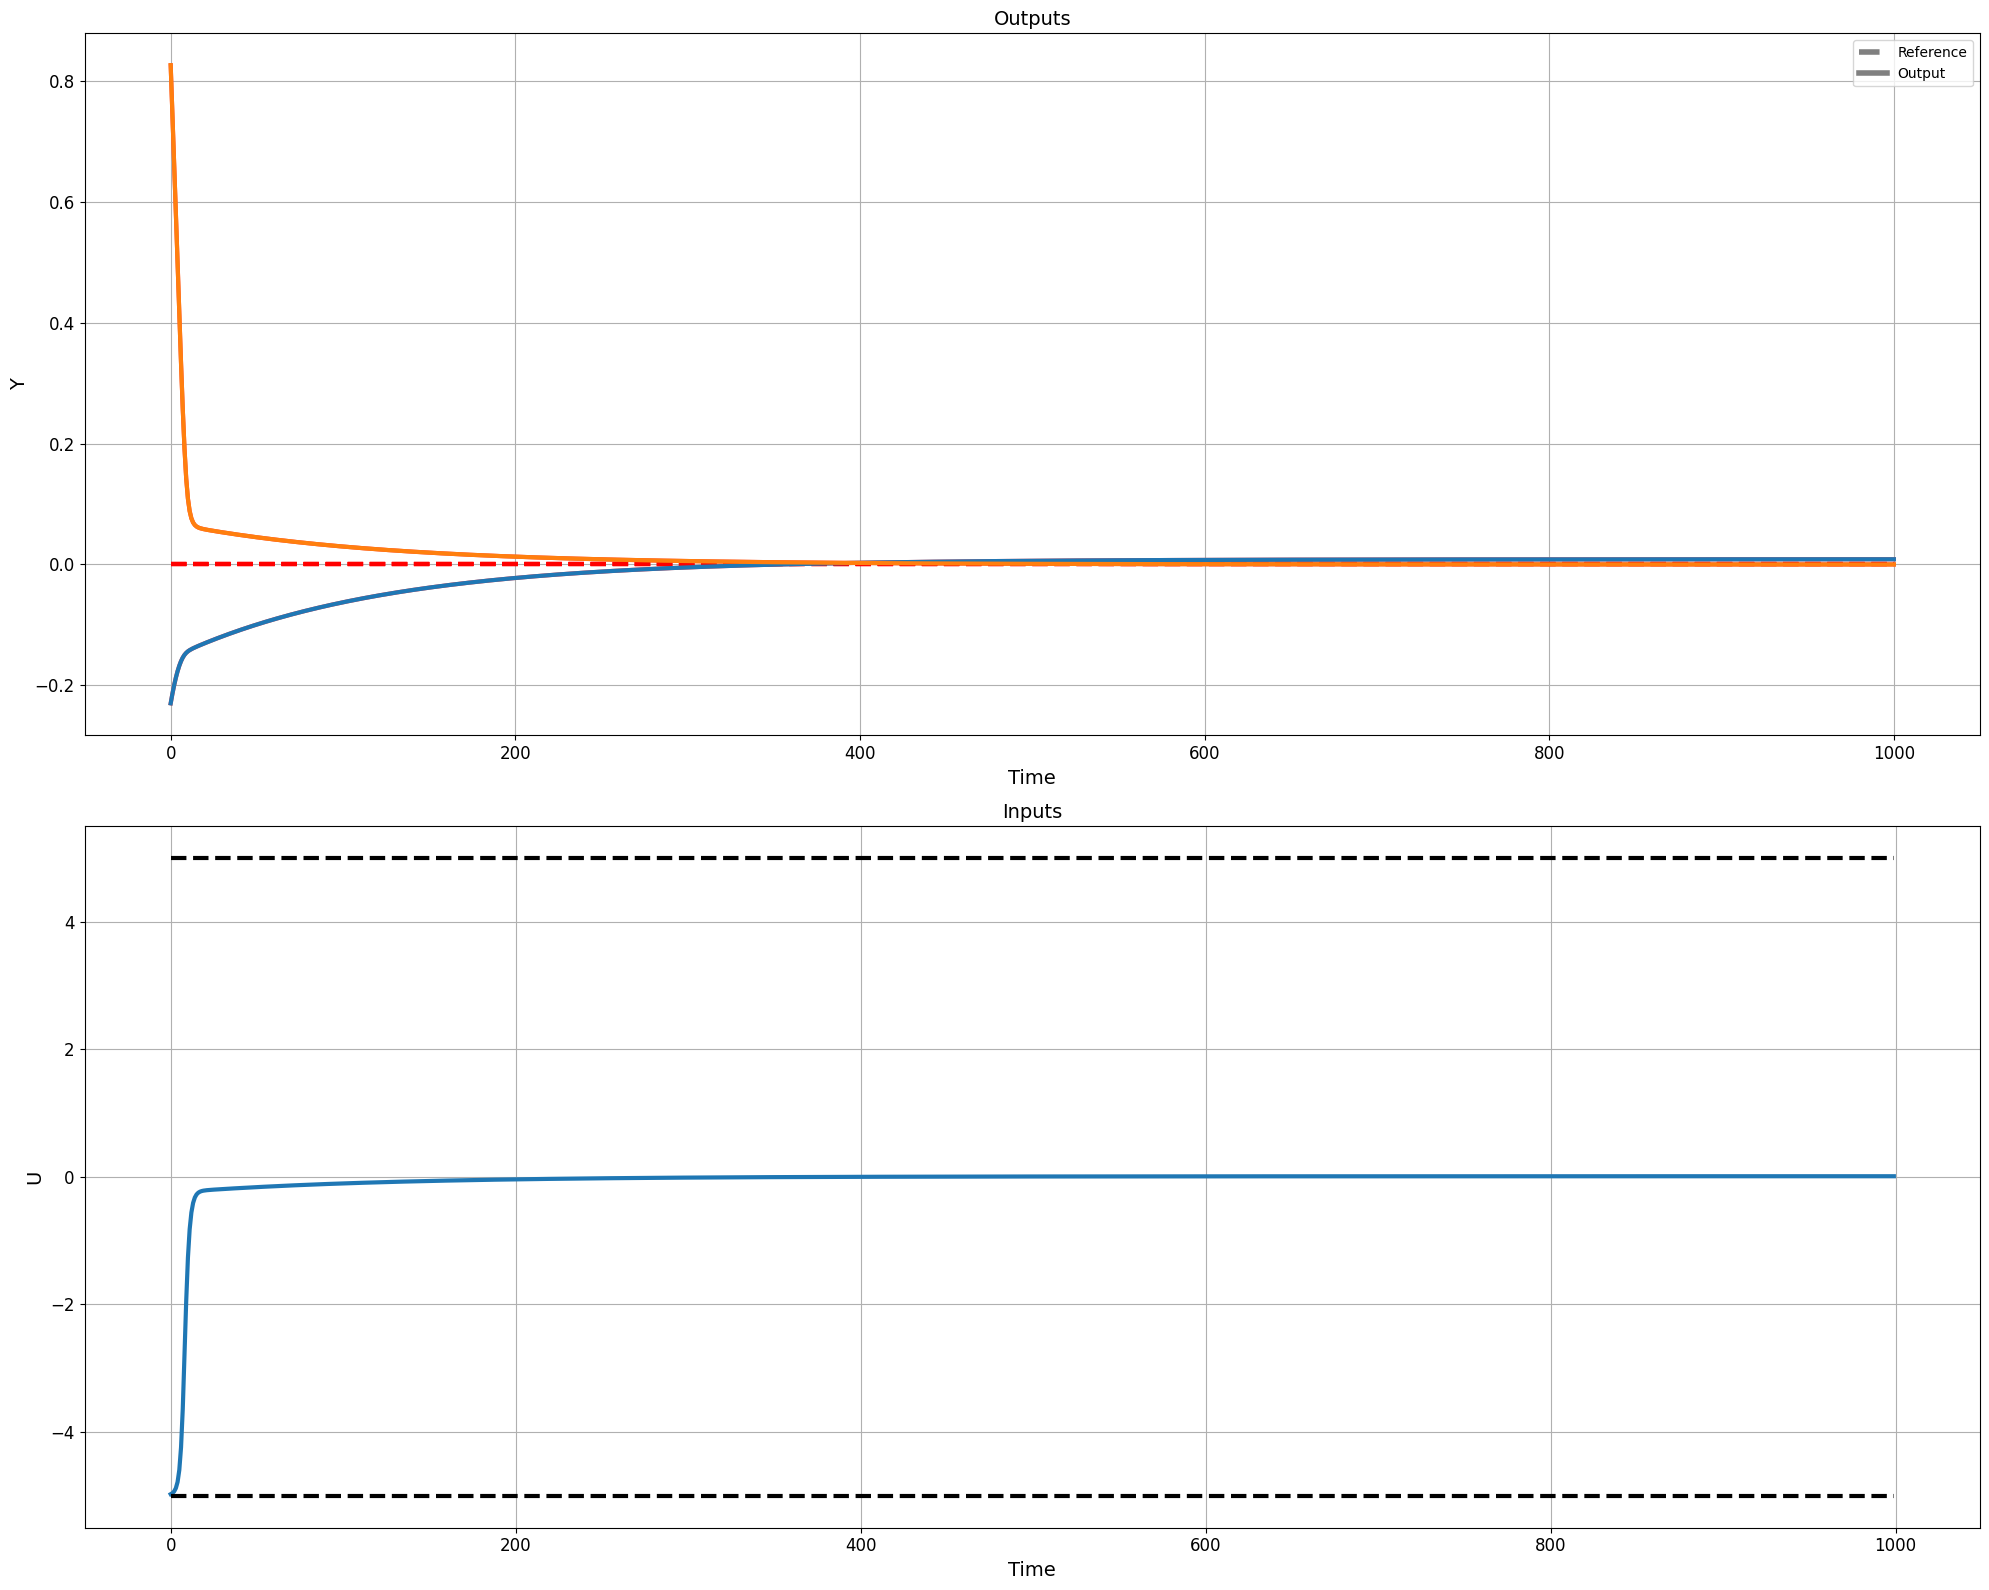

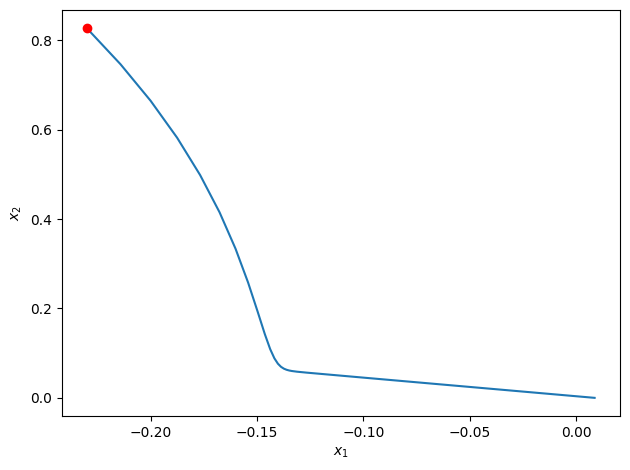

<Figure size 640x480 with 0 Axes>

In [11]:
print('\nTest Closed Loop System \n')
nsteps = 1000
# generate initial data for closed loop simulation
data = {'x': torch.randn(1, 1, nx, dtype=torch.float32),
        'r': torch.zeros(1, nsteps+1, nx, dtype=torch.float32)}
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, 1])
Umax = umax * np.ones([nsteps, 1])
Xmin = xmin * np.ones([nsteps+1, 1])
Xmax = xmax * np.ones([nsteps+1, 1])
# plot closed loop trajectories
pltCL(Y=trajectories['x'].detach().reshape(nsteps + 1, 2),
      R=trajectories['r'].detach().reshape(nsteps + 1, 2),
      U=trajectories['u'].detach().reshape(nsteps, 1),
      Umin=Umin, Umax=Umax,
      figname='cl.png')
# plot phase portrait
pltPhase(X=trajectories['x'].detach().reshape(nsteps + 1, 2),
         figname='phase.png')
